In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('data.csv')
df.head()

,ID,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,id_1,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,P
1,id_2,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,P
2,id_3,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,P
3,id_4,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,P
4,id_5,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,P


In [4]:
# Drops the objects columns from the dataset
X = df.drop(['class', 'ID'], axis='columns')
y = df['class'].map({'P': 1, 'H': 0})

In [5]:
X_scaled = StandardScaler().fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
forest.score(X_test, y_test)

0.8857142857142857

In [10]:
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Gini Importance': forest.feature_importances_}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

                  Feature  Gini Importance
413          total_time23         0.038206
269          total_time15         0.036744
252            air_time15         0.030857
107           total_time6         0.023561
396            air_time23         0.021524
..                    ...              ...
64    mean_jerk_on_paper4         0.000000
279    mean_jerk_in_air16         0.000000
273       gmrt_on_paper16         0.000000
66   mean_speed_on_paper4         0.000000
285       pressure_mean16         0.000000

[450 rows x 2 columns]


In [25]:
THRESHOLD = 0.01
count = 0

for index, row in feature_imp_df.iterrows():
    if row['Gini Importance'] < THRESHOLD:
        count += 1

print(count)

435


In [26]:
X_new = X.drop(feature_imp_df[feature_imp_df['Gini Importance'] < THRESHOLD]['Feature'], axis='columns')

In [27]:
X_new.head()

,total_time6,total_time7,total_time9,total_time13,air_time15,total_time15,air_time16,paper_time17,total_time17,num_of_pendown19,pressure_var19,air_time22,total_time22,air_time23,total_time23
0,7675,9175,4910,11720,17354,32384,3730,16625,43285,43,188183.0325,13215,18185,10965,16160
1,30080,17045,15380,6805,26535,41200,10650,49565,103935,82,270924.3100,18555,33890,14660,29900
2,5345,5965,6970,6960,22345,33695,3265,23350,50990,42,193490.8166,7425,12930,7330,13865
3,29970,13565,22255,5095,21890,28465,9850,22645,49645,78,279448.8151,8989,16079,7205,13585
4,11870,5050,7680,9005,18575,24360,805,15300,37675,53,170823.7809,3775,8835,5340,10145


In [28]:
X_new_scaled = StandardScaler().fit_transform(X_new)

In [29]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import f1_score
import pickle
# Split the data into train and test sets
test_size = 0.2  # Proportion of data to allocate to the test set
random_state = 42  # Seed for reproducibility
depths = [3, 4, 5, 6, 7]

In [30]:
data = X_scaled
scores = []
max_f1 = 0

for random_state in range(1, 20):

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=random_state)

    for depth in depths:
        clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
        clf = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #scores.append(score)

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        scores.append(f1)

        if max_f1 < f1:
            max_f1 = f1
            with open('model.pkl', 'wb') as file:
                pickle.dump(clf, file)

print("")
print(f"Number of features {data.shape[1]}")
print(f"Max f1 score: {np.max(scores):.2f}")

#clf = pickle.load(open('model.pkl', 'rb'))
#print(f"Best model accuracy {clf.score(X_test, y_test):.2f}")
#plot_tree(clf, feature_names=X_new.columns, class_names=['H', 'P'], filled=True)
#plt.savefig('reduced_tree.pdf')


Number of features 450
Max f1 score: 0.90


In [31]:
data = X_new_scaled
scores = []
max_f1 = 0

for random_state in range(1, 20):

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=random_state)

    for depth in depths:
        clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
        clf = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #scores.append(score)

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        scores.append(f1)

        if max_f1 < f1:
            max_f1 = f1
            with open('model.pkl', 'wb') as file:
                pickle.dump(clf, file)

print("")
print(f"Number of features {data.shape[1]}")
print(f"Max f1 score: {np.max(scores):.2f}")

#clf = pickle.load(open('model.pkl', 'rb'))
#print(f"Best model accuracy {clf.score(X_test, y_test):.2f}")
#plot_tree(clf, feature_names=X_new.columns, class_names=['H', 'P'], filled=True)
#plt.savefig('reduced_tree.pdf')


Number of features 15
Max f1 score: 0.90



Number of features 15
Max f1 score: 0.90
Best model accuracy 1.00


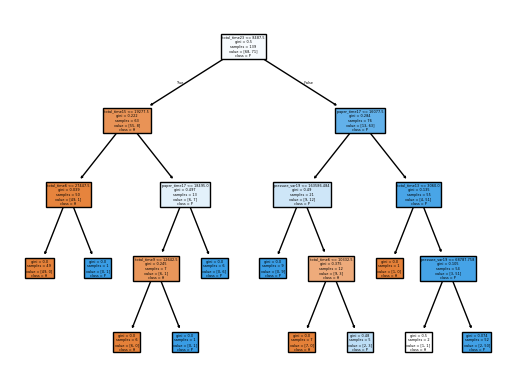

In [32]:
data = X_new
scores = []
max_f1 = 0

for random_state in range(1, 20):

    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=random_state)

    for depth in depths:
        clf = DecisionTreeClassifier(random_state=random_state, max_depth=depth)
        clf = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        #scores.append(score)

        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        scores.append(f1)

        if max_f1 < f1:
            max_f1 = f1
            with open('model.pkl', 'wb') as file:
                pickle.dump(clf, file)

print("")
print(f"Number of features {data.shape[1]}")
print(f"Max f1 score: {np.max(scores):.2f}")

clf = pickle.load(open('model.pkl', 'rb'))
print(f"Best model accuracy {clf.score(X_test, y_test):.2f}")
plot_tree(clf, feature_names=X_new.columns, class_names=['H', 'P'], filled=True)
plt.savefig('out.pdf')

/Users/eduardoduarte/miniconda3/envs/darwin/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Original Dataset feature size 15


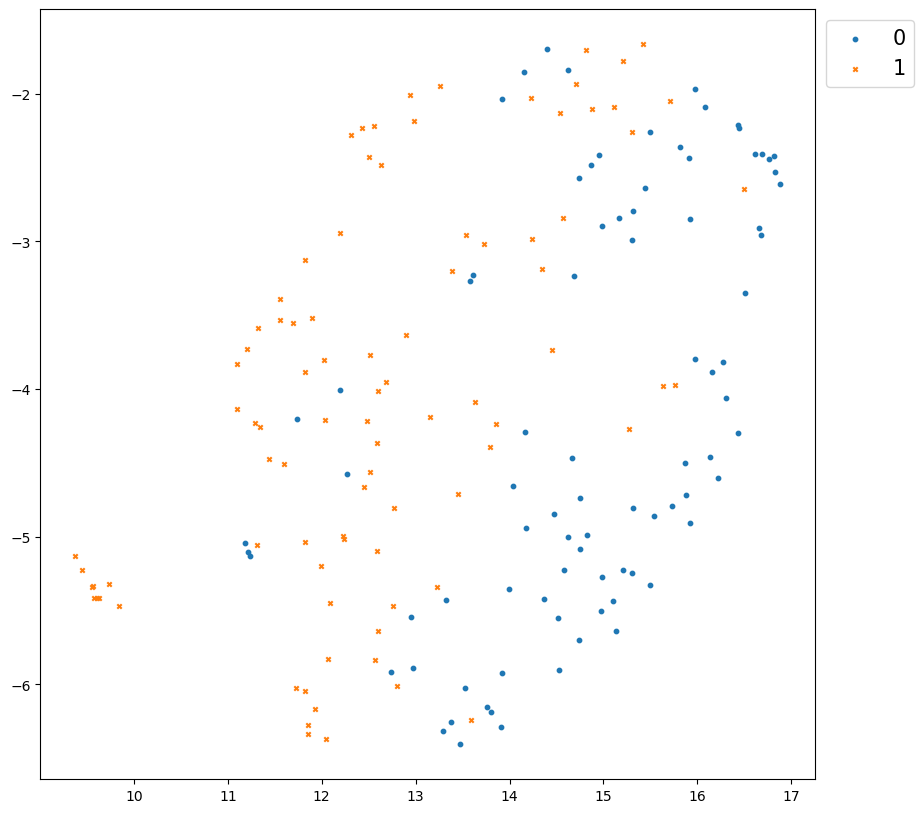

In [40]:
um = umap.UMAP()
x_umap = um.fit_transform(X_new_scaled)

plt.figure(figsize=(10,10))
for i,marker in enumerate(['o', 'x']):
    mask = y == i
    plt.scatter(x_umap[mask, 0], x_umap[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)
print(f"Original Dataset feature size {X_new_scaled.shape[1]}")

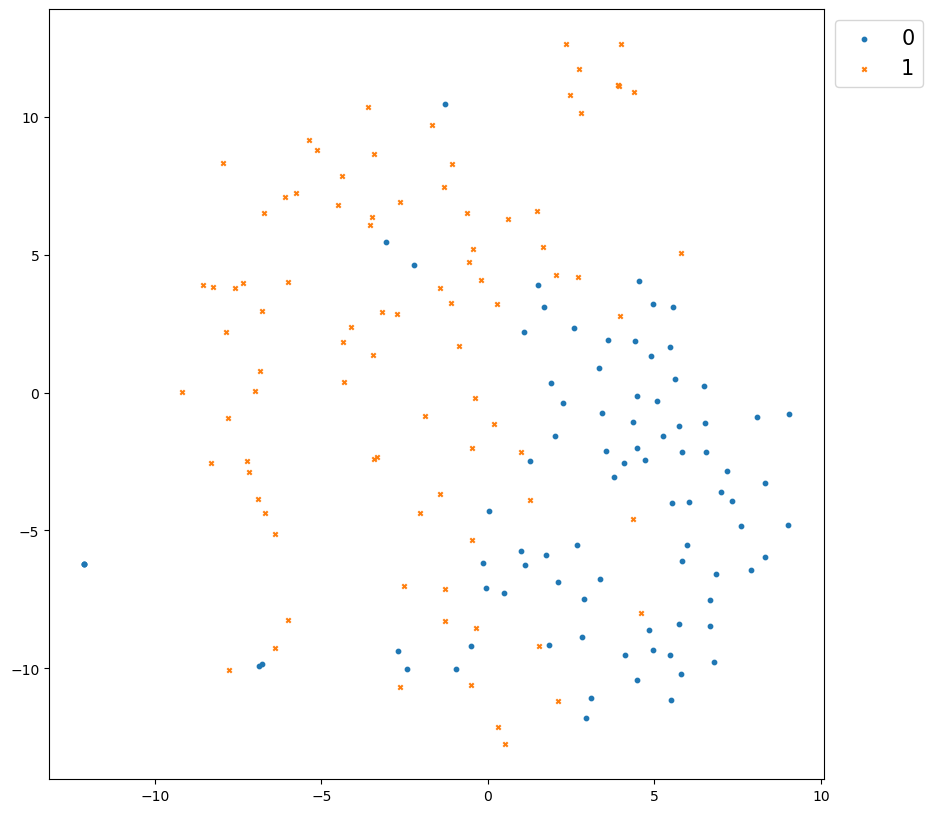

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_tsne = tsne.fit_transform(X_new_scaled)

plt.figure(figsize=(10,10))
for i,marker in enumerate(['o', 'x']):
    mask = y == i
    plt.scatter(x_tsne[mask, 0], x_tsne[mask, 1], label=i, s=10, alpha=1,marker=marker)
plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)

In [47]:
import plotly
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(X_new_scaled)

#umap_3d = TSNE(n_components=3, init='random', random_state=0)
#x_umap = umap_3d.fit_transform(X_new_scaled)

umap_df = pd.DataFrame(x_umap)
train_y_sr = pd.Series(y,name='class')
print(type(x_umap))
new_df = pd.concat([umap_df,train_y_sr],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='class', labels={'color': 'number'}
)
fig.update_traces(marker_size=3)
fig.show()

/Users/eduardoduarte/miniconda3/envs/darwin/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/eduardoduarte/miniconda3/envs/darwin/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



<class 'numpy.ndarray'>
